Aggregations 200
Timeline ticks 800
Partitions 30
Using proportional Knowledge = False


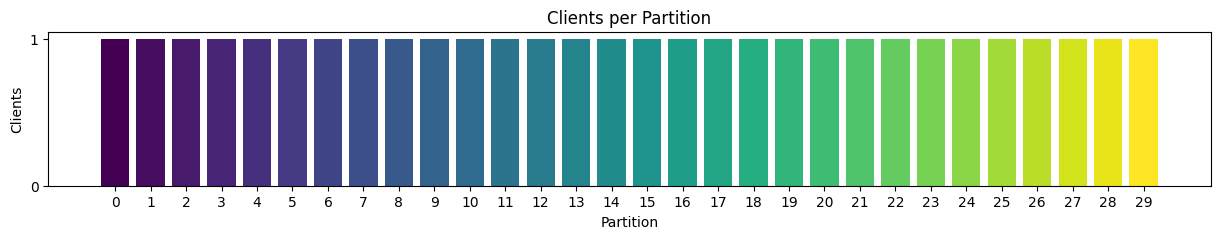

dict_keys(['npartitions', 'client_per_partition', 'proportionalKnowledge', 'cp_distr', 'naggregations'])


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tools.simulation.timeline_parser import parse_sim_export

timeline_file = "sync.json"
data = parse_sim_export(timeline_file)
timeline = data["timeline"]
simulation = data["sim"] 
aggregations = data["aggregations"]
n_partitions = simulation["npartitions"]

del data

print(f"Aggregations {len(aggregations)}")
print(f"Timeline ticks {len(timeline)}")
print(f"Partitions {n_partitions}")
print(f"Using proportional Knowledge = {simulation['proportionalKnowledge']}")

# client_per_partition List[int]
cpp = simulation["client_per_partition"]

cmap = plt.get_cmap("viridis")
partition_palette = [cmap(i) for i in np.linspace(0, 1, len(cpp))]

# blot barchar 
fig = plt.figure(figsize=(.5 * len(cpp), 2))
ax = fig.add_subplot(111)
ax.bar(range(n_partitions), cpp, color=partition_palette)
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_xticks(range(n_partitions))
ax.set_xlabel("Partition")
ax.set_ylabel("Clients")
ax.set_title("Clients per Partition")
plt.show()

print(simulation.keys())


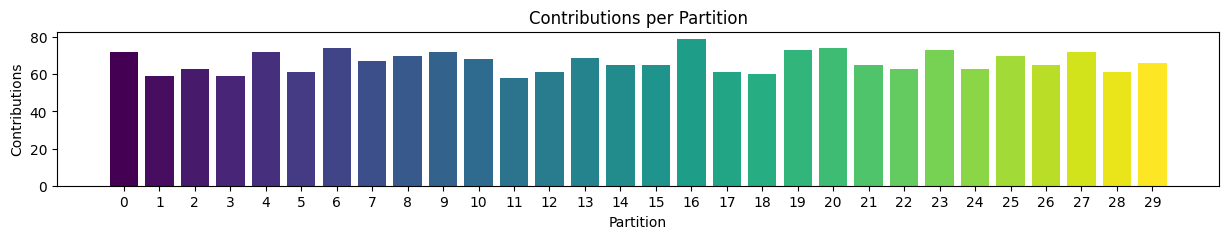

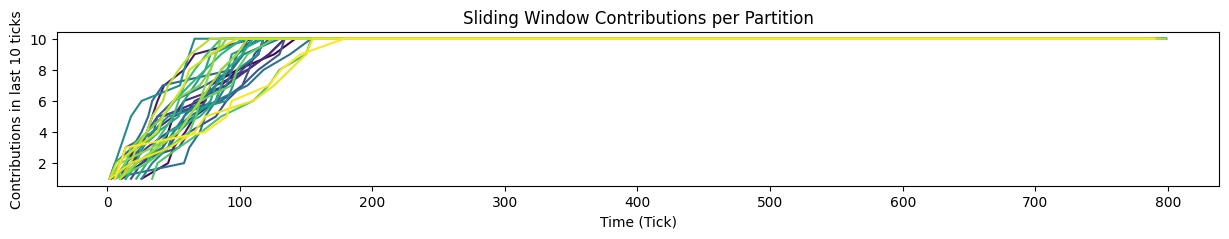

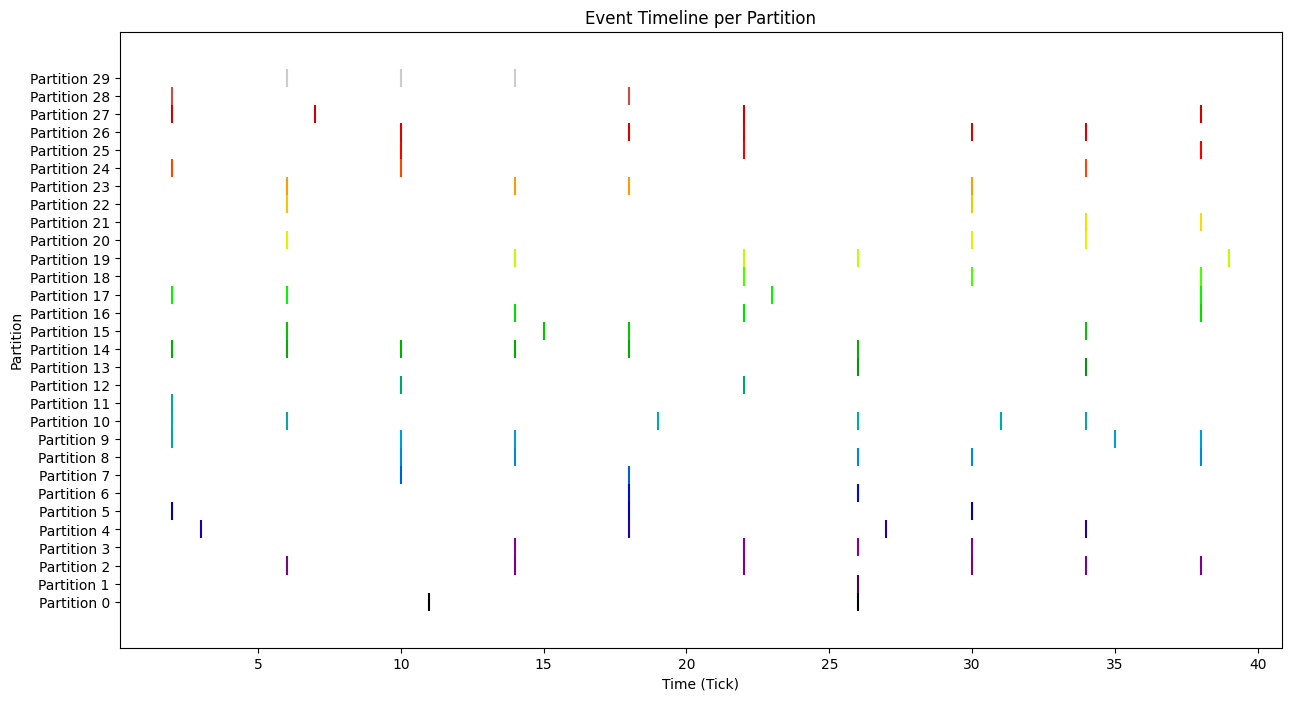

In [101]:
# plot contributions per partition

# Create a pandas dataframe of events
# ClientID, PartitionID, Tick, EType, BatchSize, Ephocs, Optimizer, LearningRate, Momentum, WeightDecay

# {'type': 'send', 'client': [5, 0], 'train_params': {'batch_size': 10, 'ephocs': 20, 'optimizer': {'type': 'sgd', 'learning_rate': 0.01, 'momentum': 0, 'weight_decay': 0}}}

event_data = []
for t, events in enumerate(timeline):
    for event in events:
        partition_id, client_id = event['client']
        event_data.append((client_id, partition_id, t, event['type'], None, None, None, None, None, None))
        if "train_params" in event:
            train_params = event['train_params']
            event_data[-1] = (client_id, partition_id, t, event['type'],
                              train_params.get('batch_size'),
                              train_params.get('ephocs'),
                              train_params.get('optimizer', {}).get('type'),
                              train_params.get('optimizer', {}).get('learning_rate'),
                              train_params.get('optimizer', {}).get('momentum'),
                              train_params.get('optimizer', {}).get('weight_decay'))

event_df = pd.DataFrame(event_data, columns=["ClientID", "PartitionID", "Tick", "EType", "BatchSize", "Ephocs", "Optimizer", "LearningRate", "Momentum", "WeightDecay"])
event_send_df = event_df[event_df['EType'] == 'send']

# plot barchart
fig = plt.figure(figsize=(.5 * n_partitions, 2))
ax = fig.add_subplot(111)
# need to get data from df instead
# ax.bar(part_contr_map.keys(), part_contr_map.values(), color=partition_palette)
ax.bar(range(n_partitions), event_send_df.groupby('PartitionID').size(), color=partition_palette)

    
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_xticks(range(n_partitions))
ax.set_xlabel("Partition")
ax.set_ylabel("Contributions")
ax.set_title("Contributions per Partition")
plt.show()

# plt now contributions over time per partition
# use a sliding window avg

# plt
fig = plt.figure(figsize=(0.5 * n_partitions, 2))
ax = fig.add_subplot(111)

window_size = 10  # number of ticks in the sliding window

for partition_id in range(n_partitions):
    # Filter data for this partition
    df_part = event_send_df[event_send_df['PartitionID'] == partition_id]

    # Count events per tick
    counts_per_tick = df_part.groupby("Tick").size()

    # Apply rolling window sum
    rolling_counts = counts_per_tick.rolling(window=window_size, min_periods=1).sum()

    # Plot
    ax.plot(
        rolling_counts.index,
        rolling_counts.values,
        label=f"Partition {partition_id}",
        color=partition_palette[partition_id]
    )

ax.set_xlabel("Time (Tick)")
ax.set_ylabel(f"Contributions in last {window_size} ticks")
ax.set_title("Sliding Window Contributions per Partition")
plt.show()

events_by_partition = [
    event_send_df.loc[event_send_df['PartitionID'] == pid, 'Tick'].values
    for pid in sorted(event_send_df['PartitionID'].unique())
]

show_until_t = 40
# filter events by time
events_by_partition = [
    list(filter(lambda x: x < show_until_t, evts)) for evts in events_by_partition
]

fig, ax = plt.subplots(figsize=(0.5 * n_partitions, 8))

ax.eventplot(events_by_partition, colors=plt.cm.nipy_spectral(
    np.linspace(0, 1, n_partitions))
)

ax.set_xlabel("Time (Tick)")
ax.set_ylabel("Partition")
ax.set_title("Event Timeline per Partition")
ax.set_yticks(range(n_partitions))
ax.set_yticklabels([f"Partition {pid}" for pid in sorted(event_send_df['PartitionID'].unique())])
plt.show()
